# `05-add-features`

Now we can make use of `sbmlcore` to add a range of structural and chemical features to the different datasets just created

In [1]:
import pandas
pandas.options.display.max_columns=999

import sbmlcore

/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/TPRParser.py:161: DeprecationWarning: 'xdrlib' is deprecated and slated for removal in Python 3.13
  import xdrlib


### Adding features

Because this is a notebook for ease of use but it has to run separately for each dataset, one has to set the `filestem` flag to each of `'traintest'`,`'validation-samples'`, `'validation-mutations'`,or `'mic'` and run the notebook each time.

In [2]:
filestem = 'validation-mutations'

assert filestem in ['traintest', 'validation-samples', 'validation-mutations', 'mic', 'all'], "dataset doesn't exist!"

In [3]:
df2 = pandas.read_csv('data/ds-' + filestem+'-phen.csv')
if 'CONSISTENT_PHENOTYPE' in df2.columns:
    df2.rename(columns={'MUTATION':'mutation', 'CONSISTENT_PHENOTYPE':'phenotype'}, inplace=True)
else:
    df2.rename(columns={'MUTATION':'mutation', 'PHENOTYPE':'phenotype'}, inplace=True)
df2[:3]


,mutation,phenotype
0,A102R,S
1,A102T,R
2,A134V,R


Instantiate a `FeatureDataset` class using `sbmlcore` and set the chain of the protein monomer

In [4]:
dataset = sbmlcore.FeatureDataset(df2, species='M. tuberculosis', gene='pncA')
dataset.df['segid'] = 'A'
dataset.df[:3]

,mutation,phenotype,segid
0,A102R,S,A
1,A102T,R,A
2,A134V,R,A


### add various changes in amino acid properties

In [5]:
features = [sbmlcore.AminoAcidVolumeChange(), sbmlcore.AminoAcidHydropathyChangeKyteDoolittle(), sbmlcore.AminoAcidPiChange(), sbmlcore.AminoAcidMWChange(), sbmlcore.AminoAcidRogovChange()]
dataset.add_feature(features)
dataset.df[:3]

,mutation,phenotype,segid,d_volume,d_hydropathy_KD,d_Pi,d_MW,d_rogov
0,A146E,R,A,49.8,-5.3,-2.78,58.0,-0.033
1,A3E,R,A,49.8,-5.3,-2.78,58.0,-0.033
2,A46E,R,A,49.8,-5.3,-2.78,58.0,-0.033


### add features measured using STRIDE

Note that this needs the `stride` binary to be compiled/installed and in your `$PATH`

In [6]:
dataset = dataset + sbmlcore.Stride('./data/reference/3PL1-PZA.pdb')
dataset.df['secondary_structure_codes'] = pandas.Categorical(dataset.df.secondary_structure, categories=dataset.df.secondary_structure.unique()).codes
dataset.df.drop(columns=['secondary_structure', 'secondary_structure_long', 'B', 'C', 'E', 'G', 'H', 'T'], inplace=True)
dataset.df[:3]

,segid,mutation,phenotype,d_volume,d_hydropathy_KD,d_Pi,d_MW,d_rogov,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,secondary_structure_codes
0,A,A3E,R,49.8,-5.3,-2.78,58.0,-0.033,-126.53,153.85,0.0,1.0,1.0,0
1,A,A30V,S,51.4,2.4,-0.04,28.0,0.232,-63.22,-36.78,38.4,1.0,1.0,1
2,A,A46E,R,49.8,-5.3,-2.78,58.0,-0.033,-131.54,158.71,0.0,1.0,1.0,0


Add the temperature ('Beta') factors from the PDB file

/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


<Axes: >

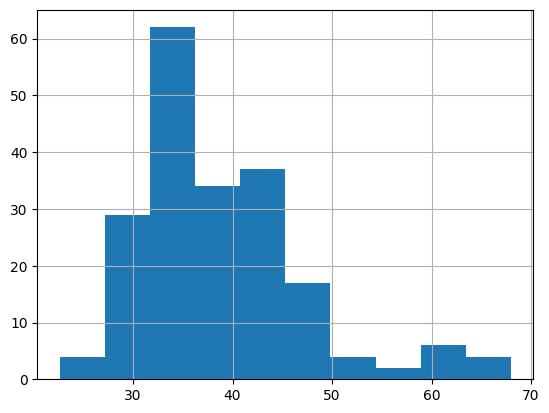

In [7]:
dataset = dataset + sbmlcore.TempFactors('data/reference/3PL1-PZA.pdb')
dataset.df.temp_factor.hist()

### add residue depth as measured by BioPython

/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=C6) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'H' for Atom (name=H6) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'N' for Atom (name=N5) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/Bio/PDB/Atom.py:232: PDBConstructionWarning: Used element 'C' for Atom (name=C4) with given element ''
  warnings.warn(msg, PDBConstructionWarning)
/Users/fowler/packages/v2/predict-py

<Axes: >

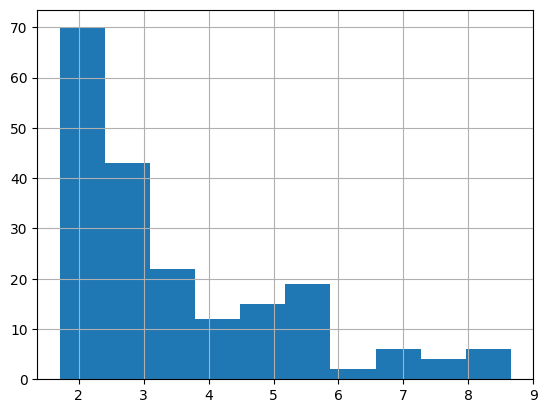

In [8]:
dataset = dataset + sbmlcore.ResidueDepth('data/reference/3PL1-PZA.pdb', segids=['A'])
dataset.df.depth.hist()

### add effect on protein stability as estimated by DeepDDG

Most mutations are predicted to be destabilising as expected

<Axes: >

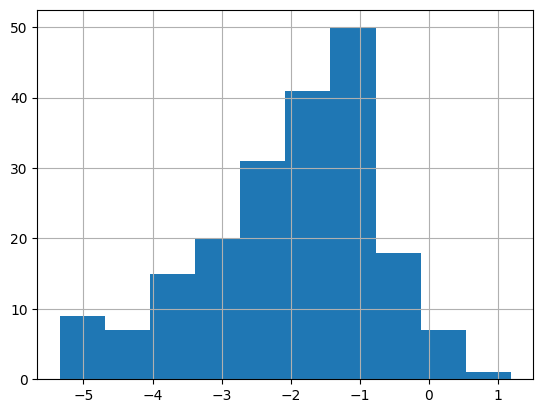

In [9]:
dataset = dataset + sbmlcore.DeepDDG('./data/features/3pl1.ddg')
dataset.df.deep_ddG.fillna(value=0, inplace=True)
dataset.df.deep_ddG.hist()

### add effect on protein stability estimated by RaSP

<Axes: >

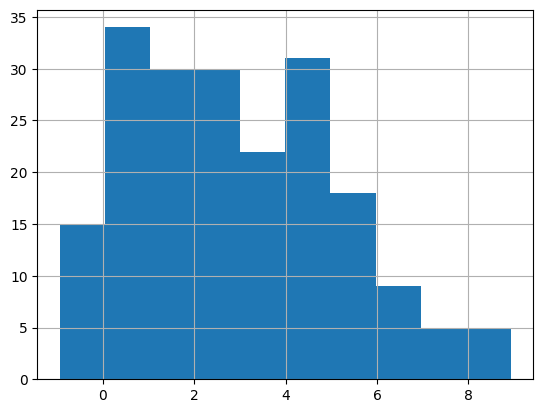

In [10]:
dataset = dataset + sbmlcore.RaSP('data/features/cavity_pred_3PL1_A.csv')
dataset.df.drop(columns=['rasp_score_ml_fermi', 'rasp_wt_nlf', 'rasp_mt_nlf'], inplace=True)
dataset.df.rasp_score_ml.hist()

## add `SNAP2` score

`SNAP2` scores range from -100 (neutral) to 100 (large effect)

<Axes: >

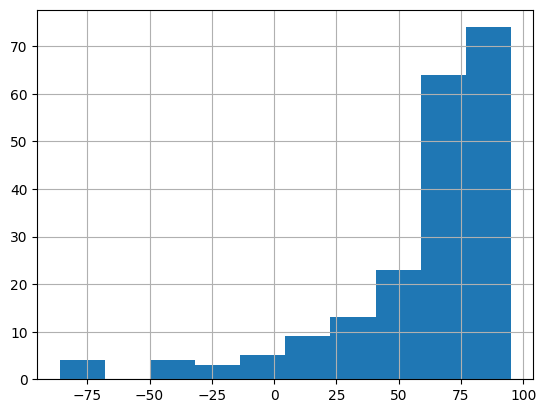

In [11]:
dataset = dataset + sbmlcore.SNAP2('./data/features/3pl1-snap2-with-segids.csv', offsets={'A': 0})
dataset.df.drop(columns=['snap2_accuracy'], inplace=True)
dataset.df.snap2_score.hist()

### add distance from the catalytic Iron 

Note you need to know the `MDAnalysis` atom selection language and how the Iron is identified in the PDB file

/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


<Axes: >

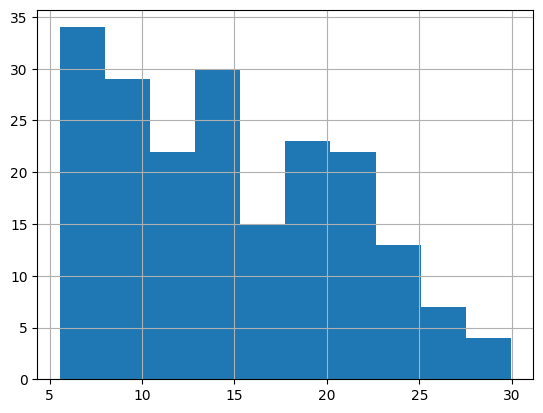

In [12]:
dataset = dataset + sbmlcore.StructuralDistances('data/reference/3PL1-PZA.pdb', 'resname FE2', 'dist_FE2')
dataset.df.dist_FE2.hist()

### add distance from the bound pyrazinamide

/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:348: UserWarning: Unknown element  found for some atoms. These have been given an empty element record. If needed they can be guessed using MDAnalysis.topology.guessers.
  warnings.warn(wmsg)
/Users/fowler/packages/v2/predict-pyrazinamide-resistance/.venv/lib/python3.11/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning: Failed to guess the mass for the following atom types: 
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))


<Axes: >

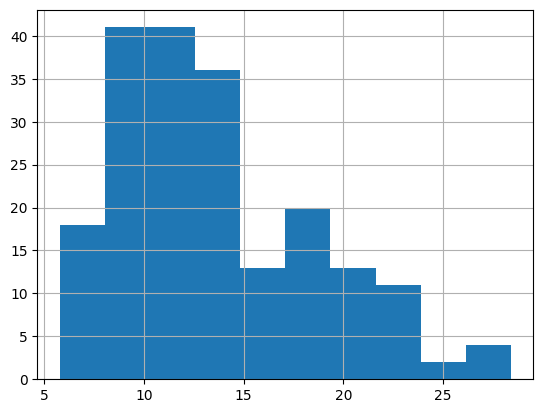

In [13]:
dataset = dataset + sbmlcore.StructuralDistances('data/reference/3PL1-PZA.pdb', 'resname PZA', 'dist_PZA', infer_masses=False)
dataset.df.dist_PZA.hist()

### add mCSM predicted stability scores

<Axes: >

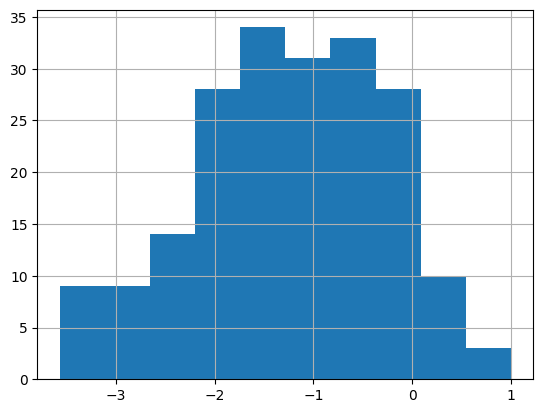

In [14]:
 # add mCSM stability
df = pandas.read_csv('data/features/3pl1-mcsm_stability.txt', sep='\t')

def create_mutation(row):
    return row['WILD_RES']+str(row.RES_POS)+row['MUT_RES']

df['mutation'] = df.apply(create_mutation, axis=1)
df = df[['mutation','RSA','PRED_DDG']]
df.rename(columns={'RSA': 'mcsm_stability_rsa', 'PRED_DDG': 'mcsm_stability_ddG'}, inplace=True)
df.drop(columns=['mcsm_stability_rsa'], inplace=True)
df.set_index('mutation', inplace=True)
df
dataset.df.set_index('mutation', inplace=True)
dataset.df = dataset.df.join(df,how='left')
dataset.df.reset_index(inplace=True)
dataset.df.mcsm_stability_ddG.hist()

### add MAPP scores

`MAPP` scores range from low (low impact) to high (high impact)

<Axes: >

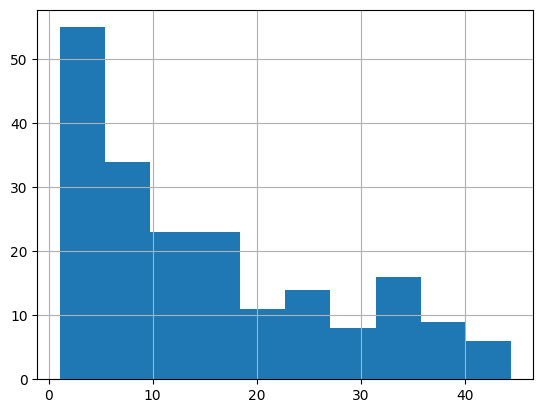

In [15]:
df = pandas.read_csv('data/features/3pl1-mapp_scores.csv')
df2 = pandas.melt(df, id_vars='Position',value_vars=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])
df2.rename(columns={'Position': 'codon', 'variable': 'alt_amino_acid', 'value': 'mapp_score'}, inplace=True)
df2.set_index(['codon', 'alt_amino_acid'], inplace=True)

def split_mutation(row):
    return pandas.Series([int(row.mutation[1:-1]), row.mutation[-1]])

df2

dataset.df[['codon', 'alt_amino_acid']] = dataset.df.apply(split_mutation, axis=1)
dataset.df.set_index(['codon', 'alt_amino_acid'], inplace=True)
dataset.df = dataset.df.join(df2,how='left')
dataset.df.reset_index(inplace=True)
dataset.df.drop(columns=['codon', 'alt_amino_acid'], inplace=True)
dataset.df.mapp_score.hist()


Finally, let's save the dataset, now with features 

In [16]:
dataset.df.to_csv('data/ds-'+filestem+'-phen-features.csv', index=False)
dataset.df.set_index('mutation', inplace=True)
dataset.df

,segid,phenotype,d_volume,d_hydropathy_KD,d_Pi,d_MW,d_rogov,phi,psi,residue_sasa,n_hbond_acceptors,n_hbond_donors,secondary_structure_codes,temp_factor,depth,deep_ddG,rasp_score_ml,snap2_score,dist_FE2,dist_PZA,mcsm_stability_ddG,mapp_score
mutation,,,,,,,,,,,,,,,,,,,,,,
M1I,A,S,3.8,2.6,0.28,-18.0,-0.452,0.00,-35.20,86.2,2.0,0.0,3,59.720001,2.103049,-0.407,0.076292,7,29.948318,27.641663,-0.771,21.99
M1T,A,R,-46.8,-2.6,-0.14,-30.1,-0.548,0.00,-35.20,86.2,2.0,0.0,3,59.720001,2.103049,-1.096,0.655765,52,29.948318,27.641663,-0.367,25.97
A3E,A,R,49.8,-5.3,-2.78,58.0,-0.033,-126.53,153.85,0.0,1.0,1.0,0,43.310001,5.503930,-5.340,3.546088,56,24.149025,21.557456,-2.528,35.68
L4S,A,R,-77.7,-4.6,-0.30,-26.1,0.015,-103.24,132.40,0.2,1.0,1.0,0,37.549999,5.075218,-2.638,4.474058,63,21.796820,18.780048,-3.567,3.41
I5S,A,R,-77.7,-5.3,-0.34,-26.1,-0.026,-113.70,111.88,0.2,1.0,1.0,0,33.880001,8.653551,-3.518,4.951083,63,17.942997,15.158482,-3.521,14.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
M175V,A,R,-22.9,2.3,0.22,-32.1,-0.514,-67.30,-49.00,0.0,3.0,2.0,1,45.490002,4.312460,-2.087,1.689107,52,21.387932,17.375624,-1.447,30.01
V180A,A,R,-51.4,-2.4,0.04,-28.0,0.232,-73.47,140.70,5.4,0.0,1.0,3,43.340000,2.863976,-2.408,3.035211,-8,23.910008,20.039579,-1.987,3.24
V180F,A,R,49.9,-1.4,-0.48,48.1,0.345,-73.47,140.70,5.4,0.0,1.0,3,43.340000,2.863976,-3.033,3.885875,57,23.910008,20.039579,-1.494,2.97
